In [1]:
import pandas as pd

In [2]:
with open('vr_demo.csv', encoding='utf-8') as f:
    df = pd.read_csv(f, skipinitialspace=True, encoding='utf-8')
df

,Base MD.Sample,Lat.Any,Long.Any,VR Mean.Any
0,1740.0,47.122103,-47.957358,0.33
1,1920.0,47.122103,-47.957358,0.39
2,2730.0,47.122103,-47.957358,0.42
3,3990.0,47.122103,-47.957358,0.49
4,4410.0,47.122103,-47.957358,0.59
...,...,...,...,...
283,2460.0,46.458936,-48.282383,0.45
284,2560.0,46.458936,-48.282383,0.47
285,2740.0,46.458936,-48.282383,0.49
286,3580.0,46.458936,-48.282383,0.67


In [3]:
def get_n_hidden_units(n_rows: int, n_features: int) -> int:
    return int(min(100, max(10, (n_features * n_rows)/5)))

hidden_layer_sizes = [get_n_hidden_units(*df.shape)]
print(f"Hidden layer sizes: {hidden_layer_sizes}")

Hidden layer sizes: [100]


In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import numpy as np

features = df.columns.values[:-1]
targets = df.columns.values[-1]
seed = 42

X, y = df[features], df[targets]
X_trn, X_test, y_trn, y_test = train_test_split(X, y, train_size=0.7, random_state=seed)

regressor = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                         random_state=seed,
                         learning_rate_init=0.0025,
                         max_iter=50000)

def build_and_eval_pipeline(regressor):
    pipeline = Pipeline(steps=[
        ('Scale', StandardScaler()),
        ('Impute', KNNImputer()),
        ('Regression', regressor)])

    pipeline.fit(X_trn, y_trn)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"R²: {r2:.3f}, RMSE: {rmse:.2f}")
    return pipeline
    
pipe = build_and_eval_pipeline(regressor)

R²: 0.574, RMSE: 0.19


In [5]:
# try with grid search
from sklearn.model_selection import GridSearchCV

param_grid = {
    "hidden_layer_sizes": [
        (100),
        #(33, 33), (50, 50), (75, 75),
        #(25, 25), (30, 20), (20, 30), 
        #(11, 11, 11), (8, 16, 8),
        #(6, 6, 6, 6), (8, 6, 4, 2)
        # est n units for same number of weights - which does better?
        # (100) is 400 weights (3 inputs * 100 + 100 * 1 output) + biases (linear scale)
        (18, 18),  # (3*18) + (18*18) + (18*1) => 396 (54+324+18)
        (13, 13, 13),  # (3*13) + (13*13) + (13*13) + (13*1) => 390 (39+169+169+13)
        (11, 11, 11, 11),      # => 407
        (9, 10, 9, 10, 9),       # => 396
    ],  
    "solver": ["lbfgs", "adam"],
    # do we need to try different random seeds to try different weight 
    # initialisations - improve changes of finding a better optima?
    # didn't help in this case
    #"random_state": [int(seed*0.5), seed, int(seed*1.5), seed*2, int(seed*2.5)], 
}

#from warnings import simplefilter
#from sklearn.exceptions import ConvergenceWarning
#simplefilter("ignore", category=ConvergenceWarning)

regressorSearch = GridSearchCV(regressor, param_grid)#, verbose=2)
pipe = build_and_eval_pipeline(regressorSearch)

regressorSearch.best_params_

R²: 0.705, RMSE: 0.16


{'hidden_layer_sizes': (13, 13, 13), 'solver': 'lbfgs'}

In [6]:
pd.DataFrame(regressorSearch.cv_results_).sort_values("rank_test_score")[0:8]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.265485,0.145137,0.000201,0.000401,"(13, 13, 13)",lbfgs,"{'hidden_layer_sizes': (13, 13, 13), 'solver':...",0.790682,0.817297,0.829383,0.851202,0.818969,0.821507,0.019587,1
8,0.246655,0.118830,0.000000,0.000000,"(9, 10, 9, 10, 9)",lbfgs,"{'hidden_layer_sizes': (9, 10, 9, 10, 9), 'sol...",0.848242,0.826198,0.811051,0.838232,0.764751,0.817695,0.029238,2
6,0.180961,0.063058,0.000400,0.000490,"(11, 11, 11, 11)",lbfgs,"{'hidden_layer_sizes': (11, 11, 11, 11), 'solv...",0.827797,0.789511,0.780846,0.756187,0.815228,0.793914,0.025361,3
2,0.290351,0.164773,0.000000,0.000000,"(18, 18)",lbfgs,"{'hidden_layer_sizes': (18, 18), 'solver': 'lb...",0.746029,0.790330,0.710908,0.836066,0.747322,0.766131,0.043091,4
0,1.246924,0.161984,0.000196,0.000393,100,lbfgs,"{'hidden_layer_sizes': 100, 'solver': 'lbfgs'}",0.775412,0.698023,0.726111,0.795547,0.734763,0.745971,0.035053,5
1,0.040725,0.012565,0.000200,0.000401,100,adam,"{'hidden_layer_sizes': 100, 'solver': 'adam'}",0.689340,0.694569,0.417148,0.698281,0.629769,0.625822,0.107305,6
9,0.047167,0.007619,0.000200,0.000400,"(9, 10, 9, 10, 9)",adam,"{'hidden_layer_sizes': (9, 10, 9, 10, 9), 'sol...",0.610511,0.641294,0.352353,0.668198,0.566978,0.567867,0.112892,7
3,0.028223,0.006316,0.000000,0.000000,"(18, 18)",adam,"{'hidden_layer_sizes': (18, 18), 'solver': 'ad...",0.634147,0.524445,0.342638,0.600509,0.594089,0.539166,0.104538,8


C:\Users\ChrisProsser\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


z min: 141.52799753597657, z max: 401.8438382184548
z min: 0.0, z max: 1.0


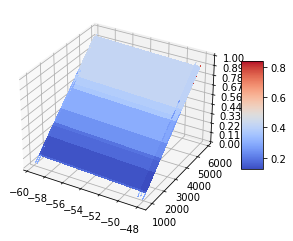

In [30]:
# try a surface plot

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
#lat = df["Lat.Any"]
long = df["Long.Any"]
depth = df["Base MD.Sample"] #Long.Any
xx, yy = np.meshgrid(long, depth)
# concatenate xx and yy and column of ones for predictions
x_predict = np.c_[np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()]
z = pipe.predict(x_predict).reshape(xx.shape)

print(f'z min: {z.min()}, z max: {z.max()}')
z = (z - z.min())/(z.max() - z.min())
print(f'z min: {z.min()}, z max: {z.max()}')

# Plot the surface.
surf = ax.plot_surface(xx, yy, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#import matplotlib.colors as mcolors

#norm = mcolors.PowerNorm(0.5)
#surf = ax.plot_surface(xx, yy, z, cmap=cm.coolwarm, norm=norm, 
#                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(z.min(), z.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [8]:
X_

0      47.122103
1      47.122103
2      47.122103
3      47.122103
4      47.122103
         ...    
283    46.458936
284    46.458936
285    46.458936
286    46.458936
287    46.458936
Name: Lat.Any, Length: 288, dtype: float64

In [9]:
XX

array([[47.122103, 47.122103, 47.122103, ..., 46.458936, 46.458936,
        46.458936],
       [47.122103, 47.122103, 47.122103, ..., 46.458936, 46.458936,
        46.458936],
       [47.122103, 47.122103, 47.122103, ..., 46.458936, 46.458936,
        46.458936],
       ...,
       [47.122103, 47.122103, 47.122103, ..., 46.458936, 46.458936,
        46.458936],
       [47.122103, 47.122103, 47.122103, ..., 46.458936, 46.458936,
        46.458936],
       [47.122103, 47.122103, 47.122103, ..., 46.458936, 46.458936,
        46.458936]])

In [10]:
YY

array([[-47.957358, -47.957358, -47.957358, ..., -47.957358, -47.957358,
        -47.957358],
       [-47.957358, -47.957358, -47.957358, ..., -47.957358, -47.957358,
        -47.957358],
       [-47.957358, -47.957358, -47.957358, ..., -47.957358, -47.957358,
        -47.957358],
       ...,
       [-48.282383, -48.282383, -48.282383, ..., -48.282383, -48.282383,
        -48.282383],
       [-48.282383, -48.282383, -48.282383, ..., -48.282383, -48.282383,
        -48.282383],
       [-48.282383, -48.282383, -48.282383, ..., -48.282383, -48.282383,
        -48.282383]])

In [13]:
ZZ

array([[[0.35535796, 0.380605  , 0.49013054, ..., 0.48042166,
         0.67266748, 0.70284539],
        [0.35535796, 0.380605  , 0.49013054, ..., 0.48042166,
         0.67266748, 0.70284539],
        [0.35535796, 0.380605  , 0.49013054, ..., 0.48042166,
         0.67266748, 0.70284539],
        ...,
        [0.35535796, 0.380605  , 0.49013054, ..., 0.48042166,
         0.67266748, 0.70284539],
        [0.35535796, 0.380605  , 0.49013054, ..., 0.48042166,
         0.67266748, 0.70284539],
        [0.35535796, 0.380605  , 0.49013054, ..., 0.48042166,
         0.67266748, 0.70284539]],

       [[0.35535796, 0.380605  , 0.49013054, ..., 0.48042166,
         0.67266748, 0.70284539],
        [0.35535796, 0.380605  , 0.49013054, ..., 0.48042166,
         0.67266748, 0.70284539],
        [0.35535796, 0.380605  , 0.49013054, ..., 0.48042166,
         0.67266748, 0.70284539],
        ...,
        [0.35535796, 0.380605  , 0.49013054, ..., 0.48042166,
         0.67266748, 0.70284539],
        [0.3